# Define canon for SMK paintings

In [1]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load smk data

We load the SMK data + metadata in a couple of different formats:

- df: Pandas DataFrame with SMK metadata on paintings (i.e., smk type "Maleri", "Akvarel", "Miniature" and "Gouache"). It's mainly "Maleri" in this category, though.

- metadata: JSON file with *all* metadata from the SMK API, not structured (indices match pickle file)

- ds: HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [4]:
# read df from pickle 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_subset.pkl'))
df.head()

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,num_creators,techniques,enrichment_url,content_person,has_text,colors,geo_location,entropy,tags_en,image
0,KKSgb20565,1803-1861,1803,Udsigt fra Rundetårn over København til Freder...,H.G.F. Holm,[H.G.F. Holm],1,Akvarel,"[Akvarel, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/w3763b937_kk...,...,1,[Blyant og vandfarve],https://enrichment.api.smk.dk/api/enrichment/K...,<NA>,<NA>,"[#d7eac3, #888888, #cccccc, #5a5527]","55.681347,12.5757299",9.284325,"[building, sky, text, sketch, art, drawing, pa...","{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."
1,KKSgb18206,1778-1841,1778,Mand med slæde,Sigmund Ferdinand Ritter von Perger,[Sigmund Ferdinand Ritter von Perger],1,Akvarel,"[Akvarel, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/ws859k68q_kk...,...,1,"[Blyant, pensel, akvarel, pen og sort blæk]",https://enrichment.api.smk.dk/api/enrichment/K...,<NA>,<NA>,"[#b7ac3e, #fcaa6b, #ffffff, #222222, #fff1dc, ...",<NA>,9.679977,"[animal, sketch, drawing, child art, reptile, ...","{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."
2,KKSgb17569,1799-1860,1799,Eksotisk fugl,Johan Christian Ernst Walter,[Johan Christian Ernst Walter],1,Gouache,"[Gouache, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/np193f181_kk...,...,1,[Gouache],https://enrichment.api.smk.dk/api/enrichment/K...,<NA>,<NA>,"[#fefcdf, #fff1dc, #d73b2e, #888888, #b93530, ...",<NA>,9.165382,"[animal, sketch, drawing, bird, child art, pai...","{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."
3,KKSgb17570,1799-1860,1799,Eksotisk fugl,Johan Christian Ernst Walter,[Johan Christian Ernst Walter],1,Gouache,"[Gouache, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/hm50tx28p_kk...,...,1,[Gouache],https://enrichment.api.smk.dk/api/enrichment/K...,<NA>,<NA>,"[#fff1dc, #ffe7c9, #77733d, #140817]",<NA>,9.195556,"[animal, sketch, drawing, bird, child art, pai...","{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."
4,KKSgb17568,1799-1860,1799,Fugl,Johan Christian Ernst Walter,[Johan Christian Ernst Walter],1,Gouache,"[Gouache, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/pc289p10p_kk...,...,1,[Gouache],https://enrichment.api.smk.dk/api/enrichment/K...,<NA>,<NA>,"[#fff1dc, #f0f3c7, #fefcdf, #956830, #3a351f, ...",<NA>,8.19523,"[animal, sketch, drawing, bird, painting, text]","{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00..."


In [3]:
# load metadata json
json_path = os.path.join(data_path, 'all_paintings_metadata')

# Open and read the JSON file
with open(json_path, 'r') as file:
    metadata = json.load(file)

In [4]:
# load image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

In [5]:
# add column with greyscale information from ds (i.e., whether the image is greyscale or not)
df['rgb'] = ds['rgb']

#### Add embeddings

In [6]:
# load embeddings
embeddings = np.load(os.path.join(data_path, 'eva02_clip_all_paintings.npy'))
embeddings.shape

(2085, 1024)

In [7]:
# load greyscaled embeddings
grey_embeddings = np.load(os.path.join(data_path, 'GREY_eva02_clip_all_paintings.npy'))
grey_embeddings.shape

(2085, 1024)

In [8]:
# need to convert to list of arrays to add to df
embeddings_list = list(embeddings)
grey_embeddings_list = list(grey_embeddings)
df['embedding'] = embeddings_list
df['grey_embedding'] = grey_embeddings_list

In [9]:
# make sure embeddings are still np arrays and has the correct shape
print(type(df['embedding'].iloc[0]))
print(df['embedding'].iloc[0].shape)
print(type(df['grey_embedding'].iloc[0]))
print(df['grey_embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
(1024,)
<class 'numpy.ndarray'>
(1024,)


In [10]:
df = df.query('main_type == "Maleri"')
indices = df.index.tolist()
df.reset_index(drop=True, inplace=True)
ds = ds.select(indices)

In [11]:
# select metadata based on indices
metadata = [metadata[i] for i in indices]

#### Extract additional information to use for canon definitions

Besides the metadata we already have in our df, we need to extract some extra data from the metadata json we can use for defining a canon of paintings and add it to our df:

In [12]:
def extract_canon_info(item):

    ''''
    Get information on canon features from smk item
    '''

    content_keys = ['exhibitions',
                    'acquisition_date', 
                    'responsible_department', 
                    'documentation', 
                    'on_display', 
                    'current_location_name',
                    'literary_reference',
                    'object_history_note']

    content_data = {field: item.get(field, pd.NA) for field in content_keys}

    return content_data

In [13]:
data_dicts = []
for item in tqdm(metadata, total=len(metadata)):
    content_data = extract_canon_info(item)
    data_dicts.append(content_data)

data_df = pd.DataFrame(data_dicts)
df = pd.concat([df, data_df], axis=1)     

100%|██████████| 1690/1690 [00:00<00:00, 403344.36it/s]


In [14]:
# get exhibition venues to check how many are from smk
def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        venues = []
        for i in range(len(exhb_dict)):
            venue = exhb_dict[i].get('venue', pd.NA)
            venues.append(venue)
        return venues
    
    else:
        return pd.NA

In [15]:
venues_list = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['exhibition_venues'] = venues_list

If a painting has been in an exhibition at SMK it will be under 'Sølvgade' (the adress for SMK) in 'venues'

In [16]:
def check_smk(venues):
    if isinstance(venues, list):
        if any(isinstance(v, str) and 'Sølvgade' in v for v in venues):
            return True 
        else:
            return False 
    else:
        return False

In [17]:
smk_exhibitions = [check_smk(venues) for venues in df['exhibition_venues']]
df['smk_exhibitions'] = smk_exhibitions

In [18]:
def extract_enrichment_wiki_info(smk_id, session):

    '''
    Make calls to enrichment API and relevant extract information
    '''
    try:
        try:
            # enrichment API can't handle slashes in the smk_id as it sees them as part of the path, so they need to be encoded properly
            encoded_smk_id = urllib.parse.quote(smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()
        
        except Exception:
            # SMK API is case insensitive but Enrichment API is not, so try to make the smk_id uppercase in case this is why the request fails
            uppercase_smk_id = smk_id.upper()
            encoded_smk_id = urllib.parse.quote(uppercase_smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()

        wiki_data = pd.NA
        for item in enrichment_json:
            if item.get('type') == 'wikidata':
                
                wiki_data = item.get('data', pd.NA).get('wikidata_link_da_s', pd.NA)
                
                break

    # if request still fails, print error message and append NA for this object
    except Exception as e:
        #print(f"Error fetching enrichment API data: {enrichment_url}")
        return pd.NA

    return wiki_data

In [281]:
# not sure we need this (and code takes some time to run)
#wiki_data_list = [extract_enrichment_wiki_info(smk_id, session) for smk_id in df['smk_id']]
#df['wiki_data'] = wiki_data_list
#df[~df['wiki_data'].isna()]

Add column with information about whether an exhibition was called something specific with 'gold'

In [19]:
golden = ['gold', 'guld']

def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        titles = []
        for i in range(len(exhb_dict)):
            title = exhb_dict[i].get('exhibition', None)

            if title:
                # Check if any keyword matches (case-insensitive)
                if any(re.search(keyword, title.lower()) for keyword in golden):
                    titles.append(title)

        return titles if titles else pd.NA
    else:
        return pd.NA 

In [20]:
golden_titles = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['golden_titles'] = golden_titles
len(df['golden_titles'].value_counts())

79

In [21]:
# convert columns to 0/1 instead of True/False
df['smk_exhibitions'] = df['smk_exhibitions']*1
df['on_display'] = df['on_display']*1

Create variable on whether the artwork has been exhibited anywhere:

In [22]:
def check_exhibitions(exhibitions):
    if isinstance(exhibitions, list):
        return 1 
    else:
        return 0 

In [23]:
exhibitions = [check_exhibitions(exb) for exb in df['exhibitions']]
df['exb_canon'] = exhibitions

### Check correlations

In [24]:
n_exhibitions_list = []
n_golden_titles_list = []

for idx, row in df.iterrows():    
    n_exhibitions_list.append(len(row['exhibition_venues']) if isinstance(row['exhibition_venues'], list) else pd.NA)
    n_golden_titles_list.append(len(row['golden_titles']) if isinstance(row['golden_titles'], list) else pd.NA)

In [25]:
df['n_exhibitions'] = n_exhibitions_list
df['n_golden_titles'] = n_golden_titles_list 

In [26]:
def n_smk_venues(venues):

    n_venues = 0

    if isinstance(venues, list):
        for v in venues:
            if isinstance(v, str) and v == 'Sølvgade':
                n_venues += 1
            else: 
                n_venues += 0
    else:
        n_venues += 0

    return n_venues

In [27]:
n_smk_exhibitions = [n_smk_venues(venues) for venues in df['exhibition_venues']]
df['n_smk_exhibitions'] = n_smk_exhibitions

In [28]:
no_na_df = df.fillna(0)

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_1836/2020816724.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  no_na_df = df.fillna(0)


In [29]:
def plot_correlation(target_column, columns):
    fig, ax = plt.subplots(1, 1, figsize = (10,4))
    columns.remove(target_column)

    for i, v in enumerate(columns):
        ax.scatter(no_na_df[target_column], no_na_df[v])
        ax.set_title(f'Correlation coef: {round(no_na_df[target_column].corr(no_na_df[v]), 3)}')
        ax.set_xlabel(target_column)
        ax.set_ylabel(v)

    fig.show()

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_1836/1478878060.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


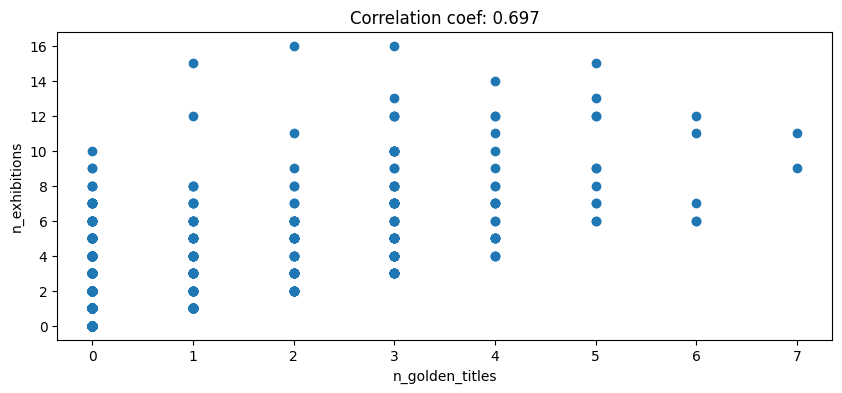

In [30]:
columns = ['n_exhibitions',
 'n_golden_titles']
plot_correlation('n_golden_titles', columns)

In [31]:
# check corr variables

df_corr = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].fillna(0)

corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_1836/625316017.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_corr = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].fillna(0)


,n_exhibitions,n_golden_titles,n_smk_exhibitions,on_display
n_exhibitions,1.000000,0.696654,0.773202,0.489196
n_golden_titles,0.696654,1.000000,0.643270,0.365066
n_smk_exhibitions,0.773202,0.643270,1.000000,0.521833
on_display,0.489196,0.365066,0.521833,1.000000


In [32]:
# check corr variables

df_corr_nona = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].dropna(how='any')

corr = df_corr_nona.corr()
corr.style.background_gradient(cmap='coolwarm')

,n_exhibitions,n_golden_titles,n_smk_exhibitions,on_display
n_exhibitions,1.000000,0.605747,0.689682,0.508893
n_golden_titles,0.605747,1.000000,0.451292,0.389436
n_smk_exhibitions,0.689682,0.451292,1.000000,0.508364
on_display,0.508893,0.389436,0.508364,1.000000


### Add column on exhibition years

In [34]:
def get_ex_years(ex_dict_list):
    
    dates = []
    if isinstance(ex_dict_list, list):
        
        for e in ex_dict_list:
            start_date = e.get('date_start', None)

            if start_date:
                start_year = start_date.split('-')[0]
                dates.append(start_year)
            else:
                dates.append(pd.NA)
        
    else:
        dates = pd.NA
    
    return dates

In [35]:
ex_dates = [get_ex_years(ex_dict_list) for ex_dict_list in df['exhibitions']]
df['ex_years'] = ex_dates

#### Add column on exhibition 'distances'

In [36]:
def get_ex_distances(row):

    prod_year = row['start_year']
    diffs = []

    if isinstance(row['ex_years'], list):
        for year in row['ex_years']:
            if isinstance(year, str):
                diff = int(year) - int(prod_year) 
                diffs.append(diff)
            else:
                diffs.append(pd.NA)
    else:
        diffs = pd.NA
    
    return diffs

In [37]:
ex_distances = [get_ex_distances(row) for idx, row in df.iterrows()]
df['ex_distances'] = ex_distances

In [38]:
def get_ex_distances_smk(row):

    if pd.notna(row['acquisition_date']):
        acq_year = row['acquisition_date'].split('-')[0]
        diffs = []

        if isinstance(row['ex_years'], list):
            for idx, year in enumerate(row['ex_years']):
                if isinstance(year, str) and isinstance(row['exhibition_venues'], list):
                    if pd.notna(row['exhibition_venues'][idx]) and row['exhibition_venues'][idx] == 'Sølvgade':
                        diff = int(year) - int(acq_year) 
                        diffs.append(diff)
                    else:
                        diffs.append(pd.NA)
                else:
                    diffs.append(pd.NA)
        else:
            diffs = pd.NA
    else:
        diffs = pd.NA
    return diffs

In [39]:
smk_distances = [get_ex_distances_smk(row) for idx, row in df.iterrows()]
df['smk_distances'] = smk_distances

In [40]:
dist_canon = []
for dists in df['ex_distances']:

    canon = 0
    if isinstance(dists, list):
        big_dists = [i for i in dists if i > 150]

        if len(big_dists) > 0:
            canon =+ 1
        else:
            canon =+ 0
        dist_canon.append(canon)
    else:
        dist_canon.append(0)

In [41]:
df['dist_canon'] = dist_canon

#### Add exhibitions canon

In [42]:
exb_canon = []

for idx, row in df.iterrows():
    exb_years = row['ex_years']

    if isinstance(exb_years, list):
        match = False
        for year in exb_years:
            if year.startswith('2') == True:
                match = True
                break
            
            else:
                continue

        if match == True:
            exb_canon.append('canon')
        
        else:
            exb_canon.append('other')

    else:
        exb_canon.append('other')

df['exb_canon'] = exb_canon

#### Make canon index by copying the formula by M. Tolonen et al. (2021)

In [43]:
no_na_df = df.fillna(0)
total_exb_count = no_na_df['n_exhibitions'].sum()

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_1836/2339353792.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  no_na_df = df.fillna(0)


In [44]:
unique_years = [np.unique(years).tolist() for years in no_na_df['ex_years']]
no_na_df['unique_exb_years'] = unique_years

In [45]:
# calculate canon index based on formula by M. Tolonen et al.
def canon_idx(row, total_exb_count):

    unique_exb_years = len(row['unique_exb_years'])

    idx = unique_exb_years * (row['n_exhibitions'] / total_exb_count)

    return idx

In [46]:
canon_idxes = [canon_idx(row, total_exb_count) for idx, row in no_na_df.iterrows()]
df['canon_idx'] = canon_idxes

In [47]:
def add_mean_prod_year(df):

    mean_years = []

    for idx, row in df.iterrows():
        if '-' in row['period']:
        #row['period'].str.contains('-'):
            start_year = int(row['period'].split('-')[0])
            end_year = int(row['period'].split('-')[-1])
        
            mean_year = (start_year + end_year) // 2
            mean_years.append(mean_year)

        else:
            mean_years.append(row['start_year'])


    df['mean_prod_year'] = mean_years

    return df

In [48]:
df = add_mean_prod_year(df)

#### Remove images

There are some objects that do not look like they are from the Golden Age:

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


0    1448
1     420
2     704
3    1608
4    1040
5     527
6     709
7      62
8      60
Name: index, dtype: int64


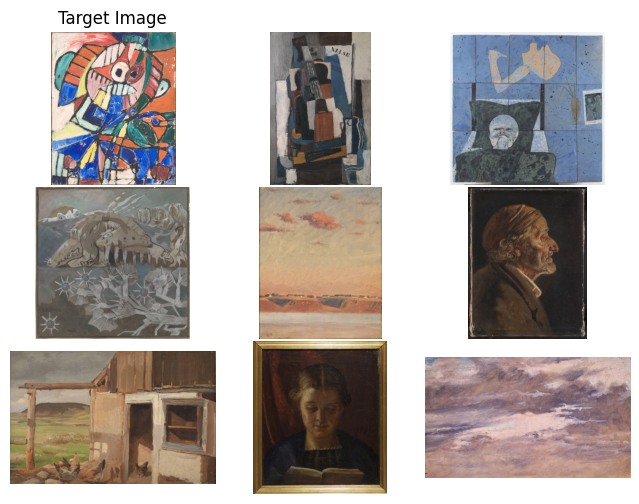

In [49]:
feature_list = np.array(df['embedding'].tolist())
plot_neighbors(feature_list, 661, ds) # choose target image I know is abstract art, not golden age

The first three paintings look a bit strange:

In [50]:
print(df['birth_death'].iloc[661])
print(df['birth_death'].iloc[1448])

['1913-2007']
['1883-1941']


We can remove these paintings - they do not look like they are from the golden age and the artists behind them was not born during this time period. Seems like a mistake in SMK's database.

The third painting is a bit more difficult: it does not look like a painting from the golden age, even though the time period says so. I have a suspicion that the painting and the metadata do not match:

Landskab med muldyr og geder


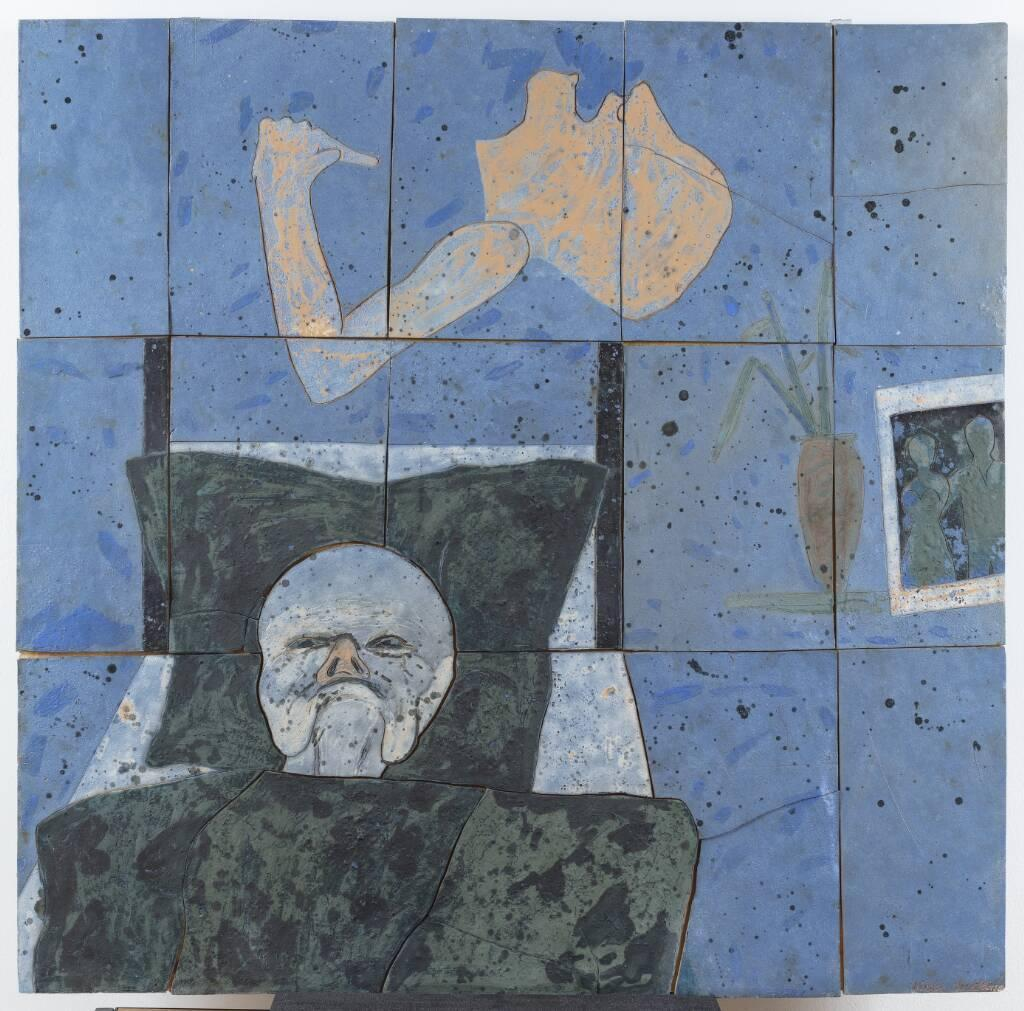

In [52]:
print(df['title'].iloc[420]) # this does not look like a 'landskab med muldyr og geder'
ds[420]['image']

In [53]:
# remove the three abstract paintings
idx_to_remove = [661, 1448, 420]

# remove duplicates
df = df.drop(idx_to_remove)

In [54]:
metadata = [metadata[i] for i in df.index.tolist()]

In [61]:
ds_new = ds.select(df.index.tolist())

In [62]:
# reset index to match metadata dict
df.reset_index(drop=True, inplace=True)

#### Check paintings with long production periods

Some of the paintings have long production periods, even up to 129 years. This is probably not accurate, so here I am finding the paintings with long production periods and saving them to a csv with more information about their production date.

In [65]:
# get range of production periods
diff_list = []
for idx, row in df.iterrows():

    if '-' in row['period']:
        start_year = int(row['period'].split('-')[0])
        end_year = int(row['period'].split('-')[-1])
        diff = end_year - start_year

        diff_list.append(diff)
    
    # if production period is just a single year, assign 0
    else:
        diff_list.append(0)

# save to df
df['prod_diff'] = diff_list

In [66]:
# get notes on 'production_date' from our metadata with all SMK's data 
prod_notes = [dict.get('production_dates_notes', pd.NA) for dict in metadata]
df['prod_notes'] = prod_notes

In [67]:
# create df with relevant variables and save to csv
prod_df = df.query('prod_diff > 20')[['period', 'prod_diff', 'prod_notes', 'birth_death', 'first_artist', 'smk_id']]
prod_df.to_csv(os.path.join(data_path, 'long_prod_paintings.csv'))

### Save to disk

In [68]:
# change canon variables from 0 / 1 to other / canon
columns = ['exb_canon', 'dist_canon', 'on_display', 'smk_exhibitions']

for column in columns:
    df[column] = df[column].replace({0: 'other', 1: 'canon'})

In [69]:
# write new df with canon info to disk
df.to_pickle(os.path.join(data_path, 'paintings_canonized.pkl'))

In [70]:
# save metadata dicts
with open(os.path.join(data_path, 'metadata_paintings'), "w") as json_file:
    json.dump(metadata, json_file, indent=2)

In [71]:
ds_new.save_to_disk(os.path.join(data_path, 'smk_only_paintings'))

Saving the dataset (1/1 shards): 100%|██████████| 1687/1687 [00:00<00:00, 7149.37 examples/s]
